# Road Lane Detection with Computer Vision

- OpenCV
- Frame Masking
- Hough Line Tranformations
- GTA Game Data Collection
- Real World Driving Data Collection

Importing needed libraries

In [13]:
import numpy as np
import cv2
import os
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Processing pipline with single frame

- Edge detection is problematic with gta video capture

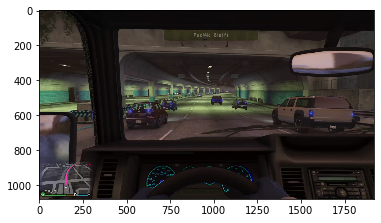

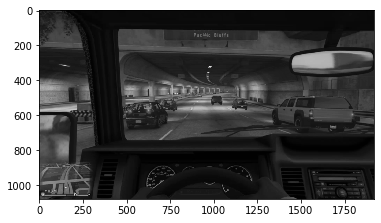

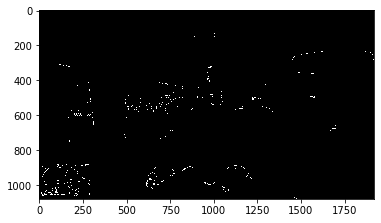

In [2]:
video = cv2.VideoCapture('data/gta_fp_day_highway_car.mp4')

# Every time this is called displays the next frame untill the video is released
ret, frame = video.read()

if ret:
    # Original Image import
    plt.imshow(frame)
    plt.show()

    # Gray and Gaussian Blur Filter
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    plt.imshow(blur, cmap='gray')
    plt.show()

    # Canny Edge Filter
    frame = cv2.Canny(blur, 100, 200)
    plt.imshow(frame, cmap='gray')
    plt.show()

# Realeses the video loop
video.release()

### Processing video as a whole

**Resize frame**

In [3]:
def resize(image):
    # Resizing image
    dim = (800, 600)
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return image

**Edge detection**

In [4]:
def canny(image):
    # Applying Canny edge detection (threshold values will have to be tweaked)
    image = cv2.Canny(image, threshold1=100, threshold2=130)
    return image

**Grayscale conversion**

In [5]:
def grey(image):
    # Processing to Grayscale (simpiler data)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

**Gaussian Blur**

In [6]:
def blur(image):
    # Adding Gaussian Blur (much more effective when applied after edge detection)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    return image

**Region masking**

In [7]:
def region(image):
    vertices = np.array([[1,500], [350,350], [450,350], [800,500]])

    mask = np.zeros_like(image)
    mask = cv2.fillPoly(mask, [vertices], 255)
    mask = cv2.bitwise_and(image, mask)
    
    return mask

**Hough Lines Algorithm**

In [8]:
def hough_lines(image):
    # Find all lines
    lines = cv2.HoughLinesP(image, 1, np.pi/180, 180, np.array([]), 100, 5)
    return lines


**Average Lines**

In [9]:
def make_points(image, average):
    slope, y_int = average
    y1 = image.shape[0]
    y2 = int(y1 * (3/5))
    x1 = int((y1 - y_int) // slope)
    x2 = int((y2 - y_int) // slope)
    return np.array([x1, y1, x2, y2])


In [10]:
def average(image, lines):
    # Find average left and right lines
    left = []
    right = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        y_int = parameters[1]
        # (all images in OpenCV have inversed y-axes)
        if slope < 0:
            left.append((slope, y_int))
        else:
            right.append((slope, y_int))

    # Calculate average points
    right_avg = np.average(right, axis=0)
    left_avg = np.average(left, axis=0)
    left_line = make_points(image, left_avg)
    right_line = make_points(image, right_avg)

    return np.array([left_line, right_line])


**Display Lines**

In [11]:
def draw_lines(image, lines):
    lines_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line
            cv2.line(lines_image, (x1, y1), (x2, y2), [255,0,0], 10)
    return lines_image

**Video Playback**

In [15]:
# Importing the video
video = cv2.VideoCapture('data/3.mov')

# Checking if video opened
if video.isOpened() == False:
    print('Error opening video file')

while video.isOpened():

    ret, frame = video.read()
    
    if ret:
        try:
            # Resizing image
            resized = resize(frame)

            # Make copy
            frame_copy = np.copy(resized)
            
            # Greyscale
            greyed = grey(frame_copy)

            # Edge detection
            edges = canny(greyed)

            # Gaussian blur
            blured = blur(edges)

            # Regionize
            isolated = region(blured)

            # Apply HoughLines
            lines = hough_lines(isolated)

            # Averages of lines
            averaged_lines = average(frame_copy, lines)

            # Display lines
            dark_lines = draw_lines(frame_copy, averaged_lines)
            lanes = cv2.addWeighted(frame_copy, 0.8, dark_lines, 1, 1)

            # Display Frame
            cv2.imshow('Frame', lanes)

            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        except:
            print('an element while processing the frame failed, passing to next frame')
            pass

    # Break the loop
    else:
        break
   
video.release()
   
# Closes all the frames
cv2.destroyAllWindows()

an element while processing the frame failed, passing to next frame
